In [1]:
import sys
sys.path.append('..')

import h5py
from proSVD import proSVD
import numpy as np
import matplotlib.pyplot as plt
import pdb
from utils.utils import *
from models.data_manager import DataManager
from models.mice_data_loader import MiceDataLoader

In [2]:
processed_dir = '/home/sachinks/Data/processed/mouse-cshl'

data_ld_1 = MiceDataLoader(None, processed_dir)
data_ld_2 = MiceDataLoader(None, processed_dir)

###
mouse_id = 'mSM49'
date = '03-Aug-2018'

filename = f'{mouse_id}_{date}_combined'

data_ld_1.init_file(mouse_id, date, cam='1')
data_ld_2.init_file(mouse_id, date, cam='2')

raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
mouse_id: mSM49
date: 03-Aug-2018
cam: 1
processed_filename: mSM49_03-Aug-2018_cam1
raw_dir: None
processed_dir: /home/sachinks/Data/processed/mouse-cshl
verbose: True
mouse_id: mSM49
date: 03-Aug-2018
cam: 2
processed_filename: mSM49_03-Aug-2018_cam2


In [3]:
video = cv2.VideoCapture(data_ld_1.get_videofilepath())
fps = video.get(cv2.CAP_PROP_FPS)

In [4]:
PROSVD_K = 4 # no. of dims to reduce to
PROSVD_INIT_FRAME = 100 # No of initial frames used to initialize proSVD

video_metadata = {
    'shape': None,
    'fps': fps
}

In [5]:
##################################
def compute_prosvd():
    g1 = stream_video(data_ld_1.get_videofilepath())
    g2 = stream_video(data_ld_2.get_videofilepath())

    frames = []  # for proSVD initialization

    # Iterate over the generator and process each batch
    for index, (frame1, frame2) in enumerate(zip(g1, g2)):
        frame1 = rgb_to_grayscale(frame1)
        frame2 = rgb_to_grayscale(frame2)

        if index > 500:
            break

        if index == 0:
            video_metadata['shape'] = frame1.shape

        frame1 = frame1.flatten()
        frame2 = frame2.flatten()
        frame = np.concatenate((frame1, frame2))

        if index < PROSVD_INIT_FRAME:
            frames.append(frame)
            continue

        if index == PROSVD_INIT_FRAME:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)

        pro.preupdate()
        pro.updateSVD(frame[:, None])
        pro.postupdate()

        dm.add('Q', pro.Q)
        dm.add('S', pro.S)
        ld = pro.Q.T@frame # loadings
        dm.add('ld', ld)
    dm.to_numpy()
##################################

dm = DataManager()
compute_prosvd()

Saving proSVD outputs

In [6]:
output_dir = '/home/sachinks/Data/output/mouse-cshl'
output_dir = f'{output_dir}/{filename}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

dm.save(output_dir)

Visualization of proSVD

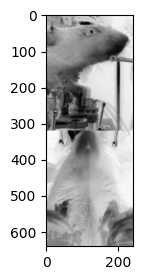

In [7]:
Q = dm.get('Q')
frame_shape = video_metadata['shape']
i = 0
Qi = Q[i]
Qi = Qi.reshape(2*frame_shape[0], frame_shape[1], PROSVD_K)
plt.figure(figsize=(3, 3))
plt.imshow(Qi[..., 0], cmap='gray')
plt.show()